# Linear Regression

All about everyone's favorite basic statistical model.

Linear regression is the first statistical model that you will learn in any statistics class, and is quite rigorously studied. Besides the basic "vanilla" version, there have been many further developments that take this method to new heights. Today, we will introduce:

* the linear regression model
* regression assumptions
* least squares estimation
* metrics: $ R^2 $, mean squared error
* regularization

There will be some math because statistical learning is inherently quite math-heavy. We usually skip a lot of math stuff as in our interests, it is usually sufficient to just implement models. To actually gain deeper understanding, however, there is a lot of math to be digested, of which we will only touch.

We will also run through an example of how to perform linear regression, specifically in this case lasso regression.

In [2]:
import pandas as pd
import numpy as np
# graphics stuff
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

## The linear regression model

The typical linear model can be expressed as

$$ y = \beta_0 + \sum_{k = 1}^n \beta_kx_k + \varepsilon $$

Here $ \beta_0 $ is the intercept, also a "fudge" parameter for fitting the model, each $ \beta_k $ is the weight for the $ k $th predictor, and each $ x_k $ is the value of the $ k $th predictor for the sample. $ \varepsilon $ is the error term of the model, as there is always natural variation in data samples, and $ y $ is the *response*, or predicted variable. 

A linear regression model posits that $ y $ is determined by a linear combination of each predictor $ x_k $, with maybe some offset specified by $ \beta_0 $. Each $ \beta_k $ acts as a weight that determines how each $ x_k $ influences $ y $. However, before we discuss fitting and using this model, we need to know the assumptions underlying it, and when we can use it. It is inappropriate, with any statistical model, to take data and "chuck it" into the model, expecting gold to come out.

Pretty pictures for the special one-variable case

$$ y = \beta_0 + \beta_1x + \varepsilon $$

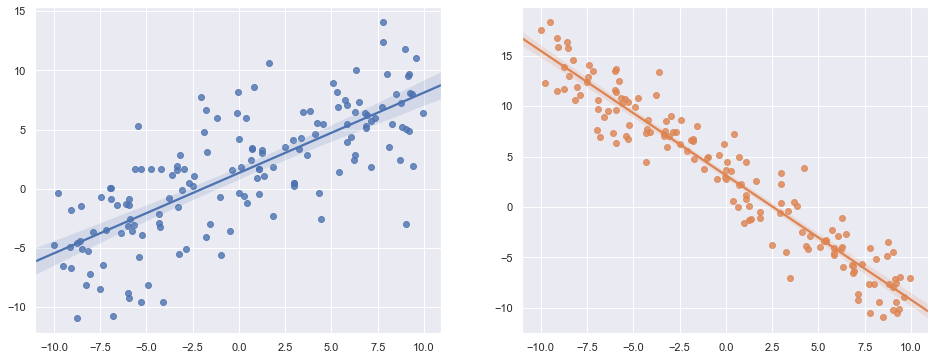

In [3]:
# number of samples
N = 150
# generate input vector from uniform draws on range [-10, 10]
X = 20 * np.random.random(N) - 10
# generate output vector which is line with slope 0.7, offset 2, and has some Normal(0, 3.1^2) noise added to it
y_a = 2 + 0.7 * X + 3.1 * np.random.randn(N)
# generate output vector which is line with slope -1.2, offset 3, and has some Normal(0, 2.2^2) noise added to it
y_b = 3 - 1.2 * X + 2.2 * np.random.randn(N)
# plot two regression lines
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))
for y, ax in zip((y_a, y_b), axs): sns.regplot(x = X, y = y, ax = ax)

Intuitively, we can interpret the $ \beta_k $ coefficient as measuring the strength of how $ y $ varies with a predictor $ x_k $. In our one predictor case, this would be the slope of the best-fit line. This also implies that given that the assumptions for linear regression hold, and there is very little multicollinearity, things we will discuss later, we can say that each $ \beta_k $ represents the sensitivity of the model to a change in $ x_k $, ceteris paribus. That is,

$$ \frac{\partial y}{\partial x_k} = \beta_k $$

## Assumptions underlying linear regression

There are several key assumptions underlying linear regression.

* Linearity
* No perfect multicollinearity
* Independence of errors
* Homoscedascity
* Normality of errors

We will tackle these one by one, and also discuss some other implicit assumptions.

### Linearity

In a nutshell, we assume that the response variable is a *linear combination* of predictors $ x_k $ and coefficients $ \beta_k $. In lay terms, it means that any changes to an $ x_k $ are the same as adding or subtracting some quantity from $ y $. What would be invalid of say a change in an $ x_k $ results in $ y $ changing into $ ay $, $ a \ne 0 $. This is a multiplicative effect, and the assumption has been violated. Note that we *can* have polynomial terms, as the linearity restriction is on the parameters. So as is common in polynomial regression, we can have an estimation function of the form

$$ \hat{f}(\mathbf{x} \mid \hat{\beta}) = \hat{\beta_0} + \sum_{k = 1}^j\hat{\beta_k}x_k^2 + \sum_{k = 1}^n\hat{\beta_k}x_k $$

that is still a valid under linear regression, as the function is linear in coefficients. This quadratic function is an arbitrary example.

The hats, $ \hat{} $, indicate estimations, and I use $ \mathbf{x} $ as the vector of predictors, with $ \hat{\beta} $ as the vector of *estimated* coefficients. We will talk about fitting later.

### No perfect multicollinearity

Well, what is multicollinearity? Multicollinearity means this: suppose we select an arbitrary $ x_k $ predictor from our $ n $ predictors.

Denote an arbitrary index set $ I \triangleq \{x \in \mathbb{N} : x \ne k, \ x \le n\} $. If we can fit the linear model

$$ \hat{x_k} = \hat{\beta_0} + \sum_{i \in I}\hat{\beta_i}x_i $$

with a relatively high degree of accuracy; i.e. we can see that $ x_k $ depends linearly quite closely with some other $ x_j $s, then there exists *multicollinearity* amongst predictors. If there is *perfect multicollinearity*, i.e. two or more of the predictors are perfectly correlated, then we **cannot** find the correct $ \beta_k $s for our model.

**Remark.** Usually, multicollinearity often does occur amongst predictors. Suppose the response does linearly depend on the predictors, and all other linear regression assumptions are met, so a linear model is a good regression choice. If there is multicollinearity, although the accuracy of the estimate $ \hat{y} $ will not be affected too much, actually values of the $ \beta_k $ parameters are highly unstable, and can vary significantly during model fitting.

You can trust(ish) the final prediction, but the each coefficient's estimate is **suspect** on its own.

### Independence of errors

We assume that the noise in the data is independent. Suppose we have $ N $ data samples, and that the error for each $ i $th sample is $ \varepsilon_i $. Independence implies

$$ \forall i, \ j = 1, \ \ldots \ N, \ i \ne j, \ \mathbb{E}[\varepsilon_i\varepsilon_j] = 0 $$

In English, the covariance of the error terms is 0; i.e. changes in one error term don't have any statistical influence on changes in another error term. 

**Remark.** Can be characterized as **uncorrelated** errors, as independence implies no correlation. Below is a Python demo of sample covariances.

In [13]:
# independent sample errors, Normal(0, 0.7^2), Normal(0, 1.6^2)
e_1, e_2 = 0.7 * np.random.randn(N * N), 1.6 * np.random.randn(N * N)
print("independent: E[e_1e_2] = {0:.4f} (almost zero)".format(sum(e_1 * e_2) / (N * N)))
# correlated, not independent errors (correlation is 0.8)
z_1, z_2 = np.random.randn(N * N), np.random.randn(N * N)
e_1 = 0.7 * z_1
e_2 = 0.8 * e_1 + np.sqrt(1 - 0.8 ** 2) * 1.6 * z_2
print(" correlated: E[e_1e_2] = {0:.4f} (definitely nonzero)".format(sum(e_1 * e_2) / (N * N)))

independent: E[e_1e_2] = 0.0043 (almost zero)
 correlated: E[e_1e_2] = 0.3849 (definitely nonzero)


### Homoscedascity

This is just a fancy term for all the errors $ \varepsilon_i $ having the same finite variance. So $ \forall i, \ j $, $ \text{Var}[\varepsilon_i] = \text{Var}[\varepsilon_j] $.

### Normality of errors

Errors $ \varepsilon_i $ are assumed to be normally distributed. We can actually summarize this and the two previous assumptions by saying that we assume

$$ \forall i, \ \varepsilon_i \sim \mathcal{N}(0, \ \sigma^2), \ \text{i.i.d.} $$

i.i.d. stands for *independent and identically distributed*.

## Least squares estimation

Now that we understand the assumptions underlying the linear regression model, how do we fit it? The fitting process is known as *least squares estimation*. We will discuss *ordinary least squares*, and introduce regularization later.

Suppose we have some multivariate data samples such that there is some function $ f $ mapping features (predictors) to the response variable $ y $. We want to learn a function $ \hat{f} $ that estimates $ f $, such that $ \hat{f} $ is as close to $ f $ as possible. That is, we want to fit $ \beta $ in such a way to minimize *error* between $ f $ and $ \hat{f} $.

One popular metric is *squared error*, which has some nice mathematical properties (besides being always nonnegative and being convex). Suppose we have $ N $ data samples. We will choose our parameter vector estimate $ \hat{\beta} $ (or more accurately, the computer does that for us using optimization methods), such that

$$ \hat{\beta} = \arg\min_\beta\{L(\mathbf{x}, y \mid \beta)\} $$

where we define $ L(\mathbf{x}, y \mid \beta) $, our *objective function*, as

$$ L(\mathbf{x}, y \mid \beta) = \sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \beta)\big)^2 $$

In English, $ \hat{\beta} $ is the chosen $ \beta $ that is the argument of the choice of $ f(\mathbf{x} \mid \beta) $ such that our objective function $ L(\mathbf{x}, y \mid \beta) $ is minimized. Our objective function $ L $ gives us the *sum of squared errors* for each $ y_i $ and estimate $ \hat{f}(\mathbf{x}_i \mid \beta) $, parameterized by $ \beta $.

See https://www.benkuhn.net/squared for an interesting post detailing in more depth why squared error is commonly used.

## Metrics

### R-squared

This stuff is cool and all, but how can measure how "accurate" a linear model is? Or in other words, how much is "explained" by the model?

Typically, we use a metric called $ R^2 $, where $ R^2 \in [0, \ 1] $ . Think of $ R^2 $ as indicating what percentage of the *variation from the sample mean* the model is able to account for. We can define $ R^2 $ as the ratio of the variation from the sample mean $ \bar{y} $ explained by our estimator $ \hat{f} $, called the *regression sum of squares*, divided by the *total sum of squares*, the variation of the data from the sample mean. So we thus have, for $ N $ samples and parameter $ \hat{\beta} $,

$$ R^2 = \frac{\sum_{i = 1}^N\big(\hat{f}(\mathbf{x}_i \mid \hat{\beta}) - \bar{y}\big)^2}{\sum_{i = 1}^N(y_i - \bar{y})^2} $$

We can also define $ R^2 $ as being $ 100\% $ minus the gap between the estimator $ \hat{f} $ and the "true" $ f $. Therefore,

$$ R^2 = 1 - \frac{\sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \hat{\beta})\big)^2}{\sum_{i = 1}^N(y_i - \bar{y})^2} = 1 - \frac{L(\mathbf{x}, y \mid \hat{\beta})}{\sum_{i = 1}^N(y_i - \bar{y})^2}$$

Here the numerator of the fraction in the second equation is termed the *residual sum of squares*, and it happens to be our objective function too.

### Mean squared error

While $ R^2 $ is useful for judging how well your model has fit the data, you may also be interested in what the average error of model estimates from $ \hat{f} $ are from the data given. One metric to measure this is *mean squared error*, or *MSE*, which is defined for $ N $ samples as

$$ MSE = \frac{1}{N}\sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \hat{\beta})\big) $$

As from the name, it is the average squared error between the data and predictions given by $ \hat{f} $. MSE is just the residual sum of squares divided by $ N $.

## Regularization

I mentioned before that linear regression comes with some additions that make it more robust. These additions take place during the fitting process, and are collectively called *regularization*. In general, regularization is defined as adding more information to help solve an ill-posed problem and prevent overfitting. Statistical learning is always an ill-posed problem, as you have a finite number of samples, and are trying to generalize from them.

In the statistical learning sense, regularization involves adding an additional penalty to the objective function $ L(\mathbf{x}, y \mid \beta) $ to prefer choices of $ \beta $ that have smaller *norms*. To introduce some notation, suppose we have a vector $ \mathbf{x} = [ \ x_1 \ \ldots \ x_n \ ]^\text{T} $. The $ L_p $-norm is defined as

$$ || \mathbf{x} ||_p = \left(\sum_{i = 1}^n|x_i|^p\right)^{1 / p} $$

Common norms are the $ L_1 $ norm, which is simply a sum of absolute values, and the $ L_2 $ norm, or *Euclidean norm*, which assigns a "length" to a vector. Generally we really only care about the $ L_1 $ and $ L_2 $ norms in regularization. The first kind of regularization we will talk about, which uses the $ L_2 $ norm, is

### Tikhonov regularization

Also known in the regression context as *ridge regression*. We modify the objective function $ L(\mathbf{x}, \ y \mid \beta) $, which we had defined as the sum of squared prediction errors, to now include weighted $ L_2 $-normed coefficients. The resulting $ L $ for $ N $ samples, in its simplest form, is now

$$ L(\mathbf{x}, \ y \mid \beta) = \sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \beta)\big)^2 + \lambda||\beta||_2^2 = \sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \beta)\big)^2 + \lambda\sum_{k = 1}^n\beta_k^2 $$

Intuitively, since when we fit the model we are trying to minimize $ L $, the extra term at the end increases the value of $ L $ when $ \beta_k $ values grow large, so the model introduces prediction *bias* (potential underfitting) to reduce prediction *variance* (potential overfitting due to learning data noise). Note that there is a tradeoff between bias and variance in the prediction error: trying to reduce one increases the other. The $ \lambda $ coefficient helps to control the regularization penalty from the normed coefficients; clearly when $ \lambda = 0 $ we are left with ordinary least squares.

Tikhonov regularization is very useful in situations where multicollinearity exists, which is common, so it is generally preferred to ordinary, or non-regularized, least square fitting when possible. However, choosing the parameter $ \lambda $ can be a bit tricky, so people generally try different estimates, using a graphical method called the *L-curve method* to qualitatively choose $ \lambda $. It was proven by Grace Wahba that there is an optimal choice in the context of a particular type of cross-validation training process, but the paper is way beyond the scope of our intro. I can also barely read the paper...small brain life.


### Lasso

Uses the $ L_1 $-norm instead of the $ L_2 $-norm used in Tikhonov regularization/ridge regression. Although the idea of coefficient size penalization is the same, lasso has one distinguishing feature from Tikhonov regularization: it can set $ \beta_k $ coefficients to 0. Therefore, in the presence of many predictors, it also serves as a method of *best subset selection*, and forces a simpler, more generalizable model to be learned. Again modifying our objective function $ L $, we have

$$ L(\mathbf{x}, \ y \mid \beta) = \sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \beta)\big)^2 + \lambda||\beta||_1 = \sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \beta)\big)^2 + \lambda\sum_{k = 1}^n|\beta_k| $$

As in Tikhonov, the $ \lambda $ parameter controls size penalization. Lasso would be preferred over ridge regression when there are many predictors, as it able to set some coefficients to 0 and therefore choose the best subset of predictors. On the other hand, ridge regression includes either all the predictors or none. Some $ \beta_k $ might be set very small, but Tikhonov regularization cannot "drop out" predictors like lasso.

If you are curious, Lasso stands for *least absolute shrinkage and selection operator*. 

## Conclusions

What did we learn? A brief summary:

#### Assumptions

We posit that $ y $ is linearly related to each $ \beta_k $, that errors $ \varepsilon $ are i.i.d. $ \varepsilon \sim \mathcal{N}(0, \ \sigma^2) $ for a finite constant $ \sigma $, and that there is no *perfect multicollinearity*.

#### Ordinary least squares

For $ N $ samples we define an objective function which is the sum of squared errors

$$ L(\mathbf{x}, \ y \mid \beta) = \sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \beta)\big)^2 $$

We run an optimization routine to minimize $ L $ such that our estimated parameter vector $ \hat{\beta} $ is

$$ \hat{\beta} = \arg\min_\beta\{L(\mathbf{x}, \ y \mid \beta)\} $$

#### Metrics

We use $ R^2 \in [0, \ 1] $ to measure the percentage of "explained" variation of $ y $ from the sample mean $ \bar{y} $. We can define $ R^2 $ in two equivalent ways: first, we can define it as the ratio of the **regression** sum of squares to **total** sum of squares, which is given by

$$ R^2 = \frac{\sum_{i = 1}^N\big(\hat{f}(\mathbf{x}_i \mid \hat{\beta}) - \bar{y}\big)^2}{\sum_{i = 1}^N(y_i - \bar{y})^2} $$

Second, we can define it as $ 100\% $ minus the ratio of **residual** sum of squares to total sum of squares, which is

$$ R^2 = 1 - \frac{\sum_{i = 1}^N\big(y_i - \hat{f}(\mathbf{x}_i \mid \hat{\beta})\big)^2}{\sum_{i = 1}^N(y_i - \bar{y})^2} = 1 - \frac{L(\mathbf{x}, y \mid \hat{\beta})}{\sum_{i = 1}^N(y_i - \bar{y})^2} $$

The last equality follows from the fact that we defined $ L $ as being the residual sum of squares.

Mean squared error gives us the **average** squared error of predictions from $ \hat{f} $ versus the actual data values $ y $. In our case, since we defined $ L $ as being the residual sum of squares, we can write the mean squared error (MSE) as $ N^{-1}L(\mathbf{x}, \ y \mid \hat{\beta}) $.


#### Regularization

We introduce bias (underfitting) to reduce prediction variance (overfitting, high test variance), which is a tradeoff. Modify $ L $ to add a penalization term based on norms of $ \beta $. Tikhonov regularization, or ridge regression, uses the $ L_2 $ norm, so we add the sum of **squared** $ \beta_k $ terms, scaled by $ \lambda \ge 0 $. Lasso we use the $ L_1 $ norm, so we add the sum of $ |\beta_k| $ terms, scaled by $ \lambda $ as well. The difference? Lasso can set coefficients to 0, and thus serves as a method of **best predictor subset selection**, and could be preferred over Tikhonov when there are many predictors and we only want to keep a **subset** of them.

## Toy lasso implementation

Here we implement toy lasso on the data set that the returning members had to fit a linear regression model on.

Credits: Nicole helped organize this bc there was too much stuff originally.

In [5]:
## import model libraries
from sklearn.linear_model import LinearRegression #basic model without regularization
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn import metrics
import scipy.stats

# visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

The data is from the [UC Irvine ML repository](http://archive.ics.uci.edu/ml/). Here we just read in the data, print what the data type is, show a little bit of the data, and get its dimensions.

**Remark.** You usually want a much larger data set than this. Tens of thousands of samples are the minimum; hundreds of thousands are recommended.

In [14]:
# read data into a DataFrame
data = pd.read_csv("../auto_mpg_data.csv")
print(data.dtypes)
print(data.head())
print(data.shape)

cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
mpg             float64
dtype: object
   cylinders  displacement  horsepower  weight  acceleration   mpg
0          8         307.0       130.0  3504.0          12.0  18.0
1          8         350.0       165.0  3693.0          11.5  15.0
2          8         318.0       150.0  3436.0          11.0  18.0
3          8         304.0       150.0  3433.0          12.0  16.0
4          8         302.0       140.0  3449.0          10.5  17.0
(392, 6)


Arbitrary problem: Given a dataset containing features about car models, predict the expected miles per gallon (mpg) of each vehicle.

What are the *features*? 

- **cylinders:** The number of cylinders in the model (numeric discrete)
- **displacement:** [engine displacement](https://en.wikipedia.org/wiki/Engine_displacement) (continuous)
- **horsepower:** horsepower of the model (continuous)
- **weight:** total weight of the car (continuous)
- **acceleration:** The vehicle acceleration rate of the model (continuous)

What is the *response*? 

- **mpg:** approximate miles per gallon of the model (continuous)

Features are your predictors, while your response is your predicted variable.


Let's check correlations between the response (mpg) and the features. We see high pairwise correlations, maybe multicollinearity too.

**Remark.** A correlation matrix cannot detect imperfect multicollinearity. High off-diagonal correlations are suspect, however.

In [19]:
data.corr()

,cylinders,displacement,horsepower,weight,acceleration,mpg
cylinders,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.777618
displacement,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.805127
horsepower,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.778427
weight,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.832244
acceleration,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.423329
mpg,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,1.000000


Now we separate our feature columns from our response column. To take full advantage of the use of the $ L_1 $-norm penalization, we will not *standardize* the features. This will be discussed more later, but remember this is a toy example, so don't expect the highest levels of sophistication.

In [16]:
# separate features from response (we chose last column as response)
feature_cols = data.columns[:-1]
resp_col = data.columns[-1]

# deep copy so we can preserve original data columns
X = data[feature_cols].copy()
y = data[resp_col].copy()

Let's take a quick look at our feature columns. Woohoo, none of them look linear, and it seems like cylinders and acceleration appear to be pretty useless.

**Remark.** There aren't too many features here, so could drop those two columns by hand. However, if there are lots of features, lasso is the lazy choice. We will see later that lasso also finds these two columns to be quite worthless as well, as it sets coefficients for those two to 0.

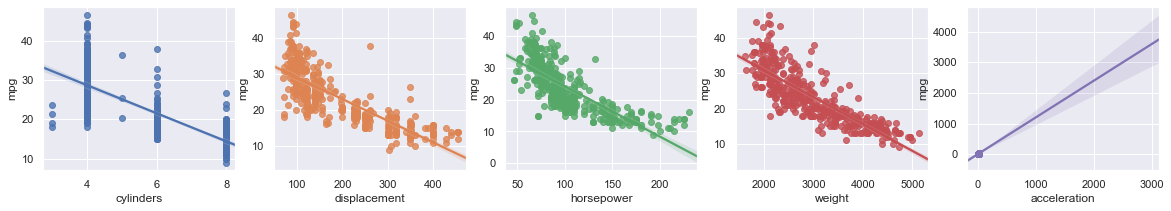

In [17]:
# plots of how mpg varies with each feature
fig, axs = plt.subplots(nrows = 1, ncols = len(feature_cols), figsize = (20, 3))
for col, ax in zip(feature_cols, axs):
    sns.regplot(x = X[col], y = y, ax = ax)

In [21]:
# instantiate and fit linear regression with Lasso regularization (L1)
lsrm = Lasso().fit(X,y)
# print the coefficients
print(" y intercept:", lsrm.intercept_)
print("coefficients:", list(zip(feature_cols,lsrm.coef_)))

 y intercept: 44.87775524611047
coefficients: [('cylinders', -0.0), ('displacement', -0.005808175080171989), ('horsepower', -0.03906606322491084), ('weight', -0.005447856146664225), ('acceleration', 0.0)]


Ok, so what did we do here?

  1. We created a matrix `X` that held our features (cylinders, displacement, horsepower, weight and acceleration) and a vector `y` that held our response variable (mpg) across all the observations in our dataset.
  2. We then instantiated (created) a `Lasso` model. 
  3. However, that model was initially untrained (didn't have our data fit to it). In order to do that, we had to call the `fit` method of the `Lasso` object `lsrm` we had just created using our features `X` and outcome `y` as input parameters.
  4. After we called `fit` on our model, the lasso regression model was fit (using math we don't have to worry about).

### How to interpret model coefficients

So, now that we've got a fitted lasso regression model, how do we interpret the $ \beta_k $ coefficients? Let's assume there is **not** a lot of multicollinearity, as recalling what we stated before, although high multicollinearity does not significantly affect the model's final accuracy, **individual** coefficients are **suspect**. Anyways:

Holding all other variables fixed, a "unit" increase in horsepower is **associated with** a ~0.0390 "unit" decrease in mpg.

Meaning: Holding all other variables fixed, an additional horsepower of 1 kW is **associated with** an decrease ~0.0390 miles per gallon.

**Remark.** Keep in mind that this is not a statement of **causation**, but of **correlation**. Statistical relationship only.

Generally, you can just think of each coefficient, assuming that our model is also linear in features $ x_k $, as

$$ \frac{\partial \hat{f}}{\partial x_k} = \beta_k $$

### How does this model perform? Let's look at $R^2$ and MSE. These are mostly used as tools for comparing models

In [22]:
# R^2
y_pred = lsrm.predict(X)
print("R^2 for lasso:",metrics.r2_score(y, y_pred))

R^2 for lasso: 0.70691485713711


In [25]:
# MSE
print("MSE for lasso:",metrics.mean_squared_error(y, y_pred))

MSE for lasso: 17.808655877106517


### Exercise Time!!
Create a linear regression with multiple variables where you only use the variables that had a $\beta$ $!= 0$ 

In [ ]:
# Create X and y


# instantiate and fit LinearRegression() model


# print coefficients and intercept


# evaluate R^2

## A More Realistic Setting

The original stuff, with an example showing how the linearity restriction is only on **parameters**, not necessarily predictors.

In all statistical learning, you want to partition your data into *training* and *test* partitions. There are more sophisticated ways to do this, such as cross-validation, but we will keep it simple and just make one split. You train the model on the training data, and then test on the test data. This is important; the average **test** performance shows you how well the model is generalizing! Never touch the test data until the model is ready to be tested.

We use the train_test_split method for this purpose, train our lasso model, and then print out the coefficients as well as the train and test model $ R^2 $. Here you can see how lasso sets the (useless) features of cylinders and acceleration to 0.

**Remark.** It is a good thing when your test accuracy exceeds your training accuracy, as it indicates that the model is generalizing well outside of its training sample. However, since our data set is very small, our test accuracy actually can vary wildly, as one can see if one decides to run this cell repeatedly.

In [26]:
# train test split (usually 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# train model on training data
lsrm = Lasso()
lsrm.fit(X_train, y_train)
# get coefficients and show train/test performance
print("coefficients {0}:\n             {1}".format(list(feature_cols), lsrm.coef_))
print("train lasso R^2: {0:.6f}\n test lasso R^2: {1:.6f}"
      "".format(lsrm.score(X_train, y_train), lsrm.score(X_test, y_test)))

coefficients ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']:
             [-0.         -0.00379066 -0.03446078 -0.00573945 -0.        ]
train lasso R^2: 0.700839
 test lasso R^2: 0.721033


We discussed before that linear models are linear only in their coefficients. The columns displacement, horsepower, and weight seem to exhibit exponential types of relationships, so let's try, for each $ x_ k $ for each $ k $th feature, the nonlinear transformation $ \log x_k $. Hopefully this makes the features more linear.

Looking at the scatterplots of how mpg varies with these new features, things are mixed. The displacement column seems to respond well. However, the horsepower column still has a bit of a curve in it. The weight column seems to be too tightly clustered to make much sense.

sub feature cols: ['displacement', 'horsepower', 'weight']


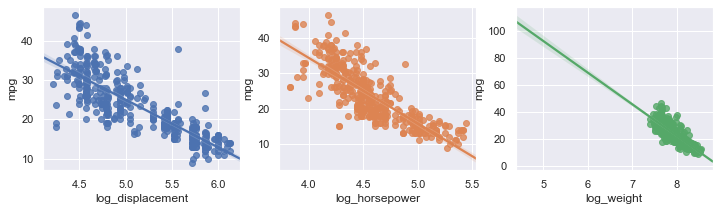

In [33]:
# sub feature columns; displacement, horsepower, and weight
sub_feature_cols = feature_cols[1:4]
print("sub feature cols: {0}".format(list(sub_feature_cols)))
# perform nonlinear transformation and change column names
Xe = np.log(data[sub_feature_cols]).copy()
Xe.columns = ["log_displacement", "log_horsepower", "log_weight"]
# show scatterplots of mpg against log features
fig, axs = plt.subplots(nrows = 1, ncols = len(Xe.columns), figsize = (12, 3))
for col, ax in zip(Xe.columns, axs):
    sns.regplot(x = Xe[col], y = y, ax = ax)

Let's try another transformation. Horsepower looks like the reciprocal function--let's try that, but also perform an square root transformation to reduce the scale of our values since many of them are quite large. Things seem to look better, although it is still a little hard to tell with the weight column.

**Remark.** This is where standardizing beforehand would be great: we can avoid the scaling issue.

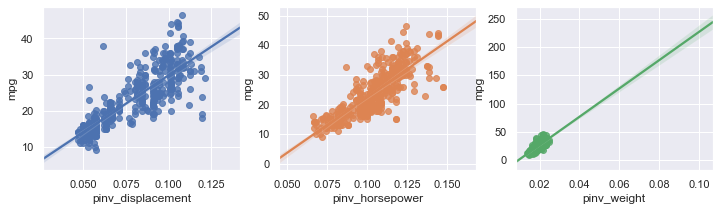

In [34]:
# perform nonlinear transformation and change column names
Xr = np.power(data[sub_feature_cols], -1 / 2).copy()
Xr.columns = ["pinv_displacement", "pinv_horsepower", "pinv_weight"]
# show scatterplots of mpg against power law features
fig, axs = plt.subplots(nrows = 1, ncols = len(Xr.columns), figsize = (12, 3))
for col, ax in zip(Xr.columns, axs):
    sns.regplot(x = Xr[col], y = y, ax = ax)

Now let's use lasso to perform a best subset selection using lasso on all of these 6 new features. First we join the dataframes together.

In [35]:
# original subset of features
print("original: {0}".format(list(sub_feature_cols)))
# our new features
print("     new: {0}".format(list(Xe.columns) + list(Xr.columns)))
# combine new features into new feature matrix
Xn = Xe.join(Xr)

original: ['displacement', 'horsepower', 'weight']
     new: ['log_displacement', 'log_horsepower', 'log_weight', 'pinv_displacement', 'pinv_horsepower', 'pinv_weight']


We now refit our lasso model on the new features only, and...it is worse than the original lasso model. Why is this?

Because by transforming our features, we have significantly reduced the **scale** of each feature. Therefore, each coefficient $ \beta_k^* $ for each transformed feature $ x_k^* $ becomes quite large. The penalization constant $ \alpha $ (we called it $ \lambda $) by default is 1, which imposes significant bias on the model estimate. Lasso is essentially "suffocating" our model by penalizing large coefficients **too** much, so most of our features got dropped.

In [40]:
# train test split on new feature matrix
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.2)
# train model on new training data
lsrm = Lasso().fit(Xn_train, y_train)
# get coefficients and show train/test performance
print("coefficients {0}:\n             {1}".format(list(Xn.columns), lsrm.coef_))
print("train linear model R^2: {0:.6f}\n test linear model R^2: {1:.6f}"
      "".format(lsrm.score(Xn_train, y_train), lsrm.score(Xn_test, y_test)))

coefficients ['log_displacement', 'log_horsepower', 'log_weight', 'pinv_displacement', 'pinv_horsepower', 'pinv_weight']:
             [-8.25684453 -0.         -0.          0.          0.          0.        ]
train linear model R^2: 0.605932
 test linear model R^2: 0.651255


Let's adjust $ \alpha $ down to reduce the penalization and see what happens. And voila, we are back in the game.

**Remark.** This is a great improvement due to increases in both the train and test $ R^2 $. However, the issue of having not enough data is apparent again. The performance of the $ \alpha $-adjusted lasso model is affected by how training and test data was split in the previous cell.

**Remark.** Our experience shows how changes in model *hyperparameters*, i.e. parameters that $ \alpha $ that change model fitting behavior independent of the data, and some minor *feature engineering*, if this even qualifies as such, can help to provide a little bit of extra gain in model accuracy. However, the main driver of model performance is the input data: as they say, *garbage in, garbage out*. The lack of sufficient quantities of training and test samples severely limits the generalization capabilities of our model. One must keep in mind that statistical learning techniques are very data hungry.

In [41]:
# train model on new training data, but with new alpha
lsrm = Lasso(alpha = 0.01).fit(Xn_train, y_train)
# get coefficients and show train/test performance
print("coefficients {0}:\n             {1}".format(list(Xn.columns), lsrm.coef_))
print("train linear model R^2: {0:.6f}\n test linear model R^2: {1:.6f}"
      "".format(lsrm.score(Xn_train, y_train), lsrm.score(Xn_test, y_test)))

coefficients ['log_displacement', 'log_horsepower', 'log_weight', 'pinv_displacement', 'pinv_horsepower', 'pinv_weight']:
             [ -1.35636274  -7.1572569  -12.72306381   0.           0.
   0.        ]
train linear model R^2: 0.734229
 test linear model R^2: 0.765062
